In [77]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import bar_chart_race as bcr

from datetime import datetime
from pytz import timezone
import plotly.express as px



In [79]:
data_dir = '/Users/Karolina/ProjectsDataScience/data_science_environment/data/'
file_list = ['MyDataSpotify/StreamingHistory0.json',
             'MyDataSpotify/StreamingHistory1.json',
             'MyDataSpotify/StreamingHistory2.json',
             'MyDataSpotify/StreamingHistory3.json',
             'MyDataSpotify/StreamingHistory4.json']

dfs = [] # an empty list to store the data frames
for file in file_list:
    data = pd.read_json(data_dir+file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.

In [80]:
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-11-21 08:21,"Does It Offend You, Yeah?",We Are Rockstars,13744
1,2020-11-21 08:25,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),256170
2,2020-11-21 08:27,"Does It Offend You, Yeah?",We Are Rockstars,69343
3,2020-11-21 08:30,"Does It Offend You, Yeah?",Doomed Now,221133
4,2020-11-21 08:31,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,2603


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47735 entries, 0 to 47734
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     47735 non-null  object
 1   artistName  47735 non-null  object
 2   trackName   47735 non-null  object
 3   msPlayed    47735 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [82]:
#double checking for duplicates
df.duplicated().sum()

0

In [83]:
df.endTime = pd.to_datetime(df.endTime, infer_datetime_format=True) 

In [84]:
#Set the current time to US Pacific timezone
df['endTimeTz']= df.endTime.dt.tz_localize(tz='UTC')

#convert US Pacific to Europe/Berlin Timezone
df['endTimeTzEU']=df.endTimeTz.dt.tz_convert(tz='Europe/Berlin')

df['hour'] = df.endTimeTzEU.dt.hour
df['date'] = df['endTime'].dt.to_period('D').apply(lambda r: r.start_time)
df['week'] = df['endTime'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['endTimeTzEU'].dt.to_period('M').apply(lambda r: r.start_time)


df['sPlayed'] = df['msPlayed']/(1000)
df['mPlayed'] = df['sPlayed']/(60)
df['hPlayed'] = df['sPlayed']/(60*60)


df['id'] = df['trackName']

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47735 entries, 0 to 47734
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype                        
---  ------       --------------  -----                        
 0   endTime      47735 non-null  datetime64[ns]               
 1   artistName   47735 non-null  object                       
 2   trackName    47735 non-null  object                       
 3   msPlayed     47735 non-null  int64                        
 4   endTimeTz    47735 non-null  datetime64[ns, UTC]          
 5   endTimeTzEU  47735 non-null  datetime64[ns, Europe/Berlin]
 6   hour         47735 non-null  int64                        
 7   date         47735 non-null  datetime64[ns]               
 8   week         47735 non-null  datetime64[ns]               
 9   month        47735 non-null  datetime64[ns]               
 10  sPlayed      47735 non-null  float64                      
 11  mPlayed      47735 non-null  float64                  

In [18]:
# based on number of streams

df_no_skips = df.loc[df['sPlayed']>10]

weekly = df_no_skips.groupby([pd.Grouper(key='endTime', freq='W'),'artistName'])['trackName'].size().reset_index()
weekly['no_csum'] = weekly.groupby(['artistName'])['trackName'].cumsum()


#choosing only top5 artist in a given week
weekly5 = weekly.set_index(['endTime', 'artistName']).groupby(level=0, group_keys=False)['no_csum'].nlargest(5)

#reformatting the data into format suitable for the bar_chart_race package
weekly5_u = weekly5.unstack()
weekly5_u.fillna(method='ffill', inplace=True)
weekly5_u.fillna(0, inplace=True)

In [21]:
# based on msPlayed

df_no_skips = df.loc[df['sPlayed']>10]

weekly_time = df_no_skips.groupby([pd.Grouper(key='endTime', freq='W'),'artistName'])['msPlayed'].sum().reset_index()
weekly_time['no_csum'] = weekly_time.groupby(['artistName'])['msPlayed'].cumsum()

#weekly_time = weekly_time.loc[weekly_time['artistName']!= 'Justin Bieber']


#choosing only top5 artist in a given week
weekly_time5 = weekly_time.set_index(['endTime', 'artistName']).groupby(level=0, group_keys=False)['no_csum'].nlargest(10)

#reformatting the data into format suitable for the bar_chart_race package
weekly_time5_u = weekly_time5.unstack()
weekly_time5_u.fillna(method='ffill', inplace=True)
weekly_time5_u.fillna(0, inplace=True)

CPU times: user 1min 4s, sys: 9.55 s, total: 1min 14s
Wall time: 1min 21s


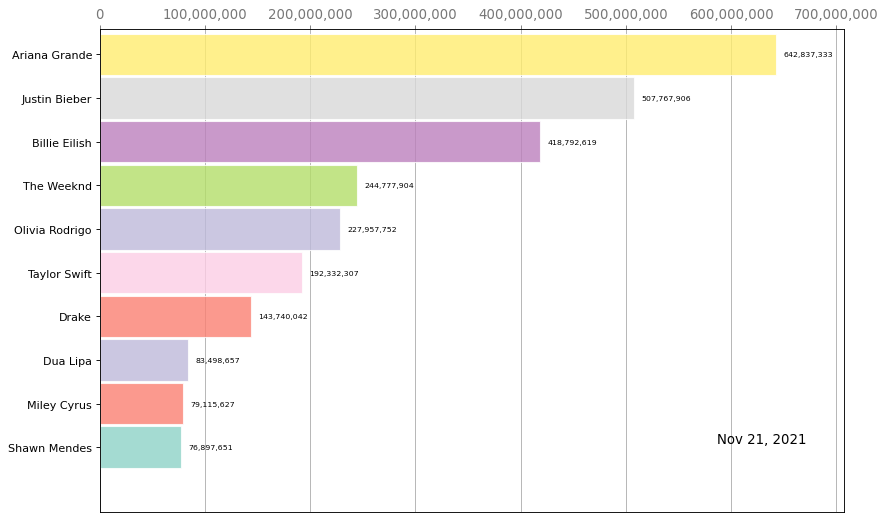

In [22]:
%%time
# help(bcr.bar_chart_race)

#initiate fig
fig, ax = plt.subplots(figsize=(12,8), facecolor='white', dpi= 80)

ax.margins(0, 0.01)
ax.set_axisbelow(True)

#ticks
ax.grid(which='major', axis='x', linestyle='-')
ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks_position('top')


bcr.bar_chart_race(df=weekly_time5_u, 
                   n_bars=10, 
                   fig=fig, 
                   period_length=400, 
                   cmap='Set3_r',
                   period_fmt='%b %-d, %Y',
                   title='The most listened artists in 2021', 
                   title_size='smaller',
                   filter_column_colors=True)

In [13]:
weekly_time.loc[weekly_time['artistName']!= 'Justin Bieber']

,endTime,artistName,msPlayed,no_csum
0,2021-01-24,AaRON,255453,255453
1,2021-01-24,Academy Chamber Choir,484453,484453
2,2021-01-24,Alexandra Steliski,170156,170156
3,2021-01-24,Andy Stringer,4477,4477
4,2021-01-24,Arden Forest,113909,113909
...,...,...,...,...
7932,2021-11-21,Travis Scott,692012,8430059
7933,2021-11-21,Two Feet,83302,16545811
7934,2021-11-21,Tyga,232932,8965742
7935,2021-11-21,Unknown Mortal Orchestra,22203,252350


In [20]:
help(bcr.bar_chart_race)

Help on function bar_chart_race in module bar_chart_race._make_chart:

bar_chart_race(df, filename=None, orientation='h', sort='desc', n_bars=None, fixed_order=False, fixed_max=False, steps_per_period=10, period_length=500, interpolate_period=False, label_bars=True, bar_size=0.95, period_label=True, period_fmt=None, period_summary_func=None, perpendicular_bar_func=None, figsize=(6, 3.5), cmap=None, title=None, title_size=None, bar_label_size=7, tick_label_size=7, shared_fontdict=None, scale='linear', writer=None, fig=None, dpi=144, bar_kwargs=None, filter_column_colors=False)
    Create an animated bar chart race using matplotlib. Data must be in 
    'wide' format where each row represents a single time period and each 
    column represents a distinct category. Optionally, the index can label 
    the time period.
    
    Bar height and location change linearly from one time period to the next.
    
    If no `filename` is given, an HTML string is returned, otherwise the 
    animat

In [13]:
test = weekly_time5_u[43:]

In [14]:
x = test.transpose().reset_index()

In [52]:
x.columns=[ 'artistName', 'nr']
x.sort_values(by='nr', ascending=True, inplace=True)
x

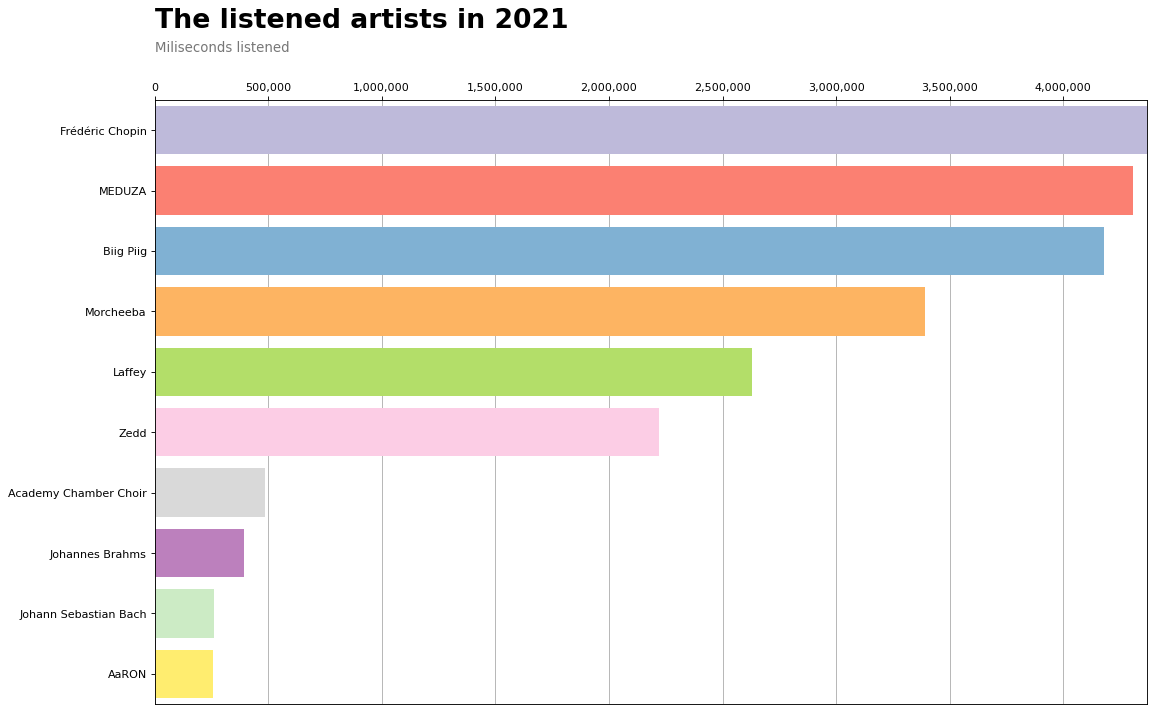

In [58]:
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
my_cmap = plt.get_cmap("Set3_r")

ax.barh(x['artistName'], x['nr'], color=my_cmap.colors)

ax.margins(0, 0.01)
ax.set_axisbelow(True)

#ticks
ax.grid(which='major', axis='x', linestyle='-')
#ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks_position('top')

#text
ax.text(0, 1.12, 'The listened artists in 2021',
            transform=ax.transAxes, size=24, weight=600, ha='left')
ax.text(0, 1.08, 'Miliseconds listened', transform=ax.transAxes, size=12, color='#777777')


plt.show()

In [76]:
df = df.loc[df['sPlayed']>10]

df_track = df.groupby(['month', 'trackName', 'artistName'], as_index=False).agg({'hPlayed':'sum', 'id':'count'})
df_track['category'] = 'Top Track'

df_artist = df.groupby(['month', 'artistName'], as_index=False).agg({'hPlayed':'sum', 'id':'count'})
df_artist['trackName'] = '' 
df_artist['category'] = 'Top Artist'

df_top = pd.concat([df_track, df_artist]).reset_index().iloc[:, 1:]

df_top['rank'] = df_top.groupby(['category', 'month'])['id'].rank(ascending=False, method='first')

df_top['total_songs'] = df_top.groupby(['category', 'month'])['id'].transform('sum')

df_top.loc[df['category'].str.contains('Track'), 'info'] = df_top.apply(lambda x: "{} - {}".format(x['trackName'], x['artistName']) , axis=1)
df_top.loc[df['category'].str.contains('Artist'), 'info'] = df_top['artistName']

df_top.loc[df['category'] == 'Top Artist', 'id'] = 100*df_top['id']/df_top['total_songs']
df_top = df_top.loc[df['rank'] <= 1]


,month,trackName,artistName,hPlayed,id,category,rank,total_songs,info
122,2020-11-01,Monster (Shawn Mendes & Justin Bieber),Shawn Mendes,7.461905,160.000000,Top Track,1.0,1075.0,Monster (Shawn Mendes & Justin Bieber) - Shawn...
769,2020-12-01,Head & Heart (feat. MNEK),Joel Corry,5.069544,115.000000,Top Track,1.0,3860.0,Head & Heart (feat. MNEK) - Joel Corry
2262,2021-01-01,Lo Vas A Olvidar (with ROSALÍA),Billie Eilish,15.488213,289.000000,Top Track,1.0,2749.0,Lo Vas A Olvidar (with ROSALÍA) - Billie Eilish
2930,2021-02-01,"Carry On (from the Original Motion Picture ""PO...",Kygo,5.708493,103.000000,Top Track,1.0,3027.0,"Carry On (from the Original Motion Picture ""PO..."
3944,2021-03-01,2 Much,Justin Bieber,5.008422,129.000000,Top Track,1.0,3735.0,2 Much - Justin Bieber
5165,2021-04-01,Save Your Tears (with Ariana Grande) (Remix),The Weeknd,12.480372,253.000000,Top Track,1.0,2925.0,Save Your Tears (with Ariana Grande) (Remix) -...
6408,2021-05-01,Under The Influence,Chris Brown,6.296013,129.000000,Top Track,1.0,3322.0,Under The Influence - Chris Brown
7353,2021-06-01,breathin,Ariana Grande,6.983557,135.000000,Top Track,1.0,2262.0,breathin - Ariana Grande
8082,2021-07-01,safety net (feat. Ty Dolla $ign),Ariana Grande,7.604413,140.000000,Top Track,1.0,2272.0,safety net (feat. Ty Dolla $ign) - Ariana Grande
8414,2021-08-01,NDA,Billie Eilish,6.147298,116.000000,Top Track,1.0,2622.0,NDA - Billie Eilish


In [75]:
spotify_colors = ['#1DB954', '#191414']
heat_pal = px.colors.sequential.YlGn

fig = px.bar(top, y='month', x='id', facet_col='category', text='info', facet_col_spacing=0.1,
                color_discrete_sequence=spotify_colors)

fig.update_yaxes(range=['2021-11-30', '2020-10-01'], tickformat='%b/%y')
fig.update_xaxes(matches=None, nticks=5)
fig.update_traces(textposition='outside')
fig.update_xaxes(col=1, title='# Streams on month', range=[0,500])
fig.update_xaxes(col=2, title='% Streams on month', ticksuffix='%', range=[0, 60])

fig.for_each_annotation(lambda a: a.update(text='<b>{}</b>'.format(a.text)))

# fig.update_traces(textposition='inside')
fig.update_layout(
    title='<b>Spotify</b>: <i>What was the top song and artist of each month?</i>',
    yaxis_title=''
)

fig.update_layout(
        template='plotly_white',
        font_family='Helvetica',
    )

fig.update_yaxes(color='grey')
fig.update_xaxes(color='grey')

fig.update_layout(margin_t=120, width=900)
fig.update_traces(textfont_size=14)

fig.for_each_annotation(lambda a: a.update(font_size=14))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))


In [92]:
conditions = [df['artistName'] == 'Justin Bieber', 
              df['mPlayed'] >= 10.22]

outputs = ['Justin Bieber', 'Podcast']

df['streamType'] = np.select(conditions, outputs, 'Music')
df.head()

,endTime,artistName,trackName,msPlayed,endTimeTz,endTimeTzEU,hour,date,week,month,sPlayed,mPlayed,hPlayed,id,streamType
0,2020-11-21 08:21:00,"Does It Offend You, Yeah?",We Are Rockstars,13744,2020-11-21 08:21:00+00:00,2020-11-21 09:21:00+01:00,9,2020-11-21,2020-11-16,2020-11-01,13.744,0.229067,0.003818,We Are Rockstars,Music
1,2020-11-21 08:25:00,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),256170,2020-11-21 08:25:00+00:00,2020-11-21 09:25:00+01:00,9,2020-11-21,2020-11-16,2020-11-01,256.170,4.269500,0.071158,With A Heavy Heart (I Regret To Inform You),Music
2,2020-11-21 08:27:00,"Does It Offend You, Yeah?",We Are Rockstars,69343,2020-11-21 08:27:00+00:00,2020-11-21 09:27:00+01:00,9,2020-11-21,2020-11-16,2020-11-01,69.343,1.155717,0.019262,We Are Rockstars,Music
3,2020-11-21 08:30:00,"Does It Offend You, Yeah?",Doomed Now,221133,2020-11-21 08:30:00+00:00,2020-11-21 09:30:00+01:00,9,2020-11-21,2020-11-16,2020-11-01,221.133,3.685550,0.061426,Doomed Now,Music
4,2020-11-21 08:31:00,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,2603,2020-11-21 08:31:00+00:00,2020-11-21 09:31:00+01:00,9,2020-11-21,2020-11-16,2020-11-01,2.603,0.043383,0.000723,Being Bad Feels Pretty Good,Music


In [118]:
df.groupby(['artistName', 'trackName'], as_index=False).agg({'hPlayed':'sum', 'id':'count'}).sort_values(by='hPlayed', ascending=False).head(15)


,artistName,trackName,hPlayed,id
7798,The Weeknd,Save Your Tears (with Ariana Grande) (Remix),21.312132,465
1024,Billie Eilish,Lo Vas A Olvidar (with ROSALÍA),20.154791,417
598,Ariana Grande,safety net (feat. Ty Dolla $ign),17.426392,367
1021,Billie Eilish,Happier Than Ever,16.939484,260
6598,SZA,Good Days,15.542207,269
593,Ariana Grande,pov,13.412932,303
5854,Olivia Rodrigo,drivers license,13.082600,256
6908,Shawn Mendes,Monster (Shawn Mendes & Justin Bieber),11.995305,278
3043,H.E.R.,Come Through (feat. Chris Brown),11.695136,237
1038,Billie Eilish,Your Power,10.240236,209


In [114]:
df_podcasts = df.loc[df['streamType']=='Podcast']

In [113]:
top_podcasts = df_podcasts.groupby(['artistName'], as_index=False).agg({'hPlayed':'sum', 'id':'count'}).sort_values(by='hPlayed', ascending=False)
top_podcasts = top_podcasts.head(10)
top_podcasts.reset_index(inplace=True)
top_podcasts

,index,artistName,hPlayed,id
0,16,Huberman Lab,13.836447,24
1,36,The Daily,11.909077,29
2,39,The Tim Ferriss Show,11.314454,21
3,37,The Dropout,7.812180,19
4,30,Spotify: A Product Story,6.801876,18
5,1,Armchair Expert with Dax Shepard,5.364319,8
6,41,Unlocking Us with Brené Brown,3.731638,9
7,9,Dr. Death | S1: Dr. Duntsch,3.520076,8
8,22,Karolina Sobańska,2.912650,6
9,15,How I Built This with Guy Raz,2.189291,3


In [112]:
fig = px.bar(top_podcasts, y='artistName', x='hPlayed', facet_col_spacing=0.1,
                color_discrete_sequence=spotify_colors)

fig.update_yaxes(autorange='reversed', zeroline=False, tickfont_size=14)
fig.update_xaxes(rangemode='tozero', range=[-0.5, 20], tickfont_size=14)

fig.update_layout(
        template='plotly_white',
        font_family='Helvetica',
    )

fig.update_yaxes(color='grey')
fig.update_xaxes(color='grey')

fig.update_layout(
    title='<b>Spotify</b>: <i>What were my top podcasts of the year?</i>',
    xaxis_title='Hours Listened',
    yaxis_title='Top 10 most listened podcasts'
)

fig.show()